In [90]:
using MLJ, CSV, DataFrames, UrlDownload, BenchmarkTools

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/heart/heart.dat";
feature_names = ["age", "sex", "chest_pain", "rest_bp", "serum_cholestrol", "fasting_blood_sugar", "rest_ECG", "max_HR", "ex_ind_ang", "oldpeak",
"slope", "major_vessel", "thal","heart_dis"]
data = urldownload(url, true, format = :CSV, header = feature_names);
s_log = DataFrame(data)
schema(s_log)

┌─────────────────────┬─────────┬────────────┐
│ _.names             │ _.types │ _.scitypes │
├─────────────────────┼─────────┼────────────┤
│ age                 │ Float64 │ Continuous │
│ sex                 │ Float64 │ Continuous │
│ chest_pain          │ Float64 │ Continuous │
│ rest_bp             │ Float64 │ Continuous │
│ serum_cholestrol    │ Float64 │ Continuous │
│ fasting_blood_sugar │ Float64 │ Continuous │
│ rest_ECG            │ Float64 │ Continuous │
│ max_HR              │ Float64 │ Continuous │
│ ex_ind_ang          │ Float64 │ Continuous │
│ oldpeak             │ Float64 │ Continuous │
│ slope               │ Float64 │ Continuous │
│ major_vessel        │ Float64 │ Continuous │
│ thal                │ Float64 │ Continuous │
│ heart_dis           │ Int64   │ Count      │
└─────────────────────┴─────────┴────────────┘
_.nrows = 270


In [91]:
################# Assessing the data and Fixing scientific types in tabular data ############

In [92]:
describe(s_log)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,age,54.4333,29.0,55.0,77.0,0,Float64
2,sex,0.677778,0.0,1.0,1.0,0,Float64
3,chest_pain,3.17407,1.0,3.0,4.0,0,Float64
4,rest_bp,131.344,94.0,130.0,200.0,0,Float64
5,serum_cholestrol,249.659,126.0,245.0,564.0,0,Float64
6,fasting_blood_sugar,0.148148,0.0,0.0,1.0,0,Float64
7,rest_ECG,1.02222,0.0,2.0,2.0,0,Float64
8,max_HR,149.678,71.0,153.5,202.0,0,Float64
9,ex_ind_ang,0.32963,0.0,0.0,1.0,0,Float64


In [93]:
autotype(s_log)

Dict{Symbol, Type} with 9 entries:
  :rest_ECG            => OrderedFactor
  :chest_pain          => OrderedFactor
  :fasting_blood_sugar => OrderedFactor
  :major_vessel        => OrderedFactor
  :sex                 => OrderedFactor
  :ex_ind_ang          => OrderedFactor
  :thal                => OrderedFactor
  :slope               => OrderedFactor
  :heart_dis           => OrderedFactor

In [94]:
coerce!(s_log, autotype(s_log));
schema(s_log)

┌─────────────────────┬───────────────────────────────────┬──────────────────┐
│ _.names             │ _.types                           │ _.scitypes       │
├─────────────────────┼───────────────────────────────────┼──────────────────┤
│ age                 │ Float64                           │ Continuous       │
│ sex                 │ CategoricalValue{Float64, UInt32} │ OrderedFactor{2} │
│ chest_pain          │ CategoricalValue{Float64, UInt32} │ OrderedFactor{4} │
│ rest_bp             │ Float64                           │ Continuous       │
│ serum_cholestrol    │ Float64                           │ Continuous       │
│ fasting_blood_sugar │ CategoricalValue{Float64, UInt32} │ OrderedFactor{2} │
│ rest_ECG            │ CategoricalValue{Float64, UInt32} │ OrderedFactor{3} │
│ max_HR              │ Float64                           │ Continuous       │
│ ex_ind_ang          │ CategoricalValue{Float64, UInt32} │ OrderedFactor{2} │
│ oldpeak             │ Float64                     

In [95]:
coerce!(s_log,
          :presence => OrderedFactor,
          :exang    => OrderedFactor,
          :sex      => OrderedFactor,
          :fbs      => OrderedFactor,
          :restecg  => Multiclass,
          :slope    => OrderedFactor,
          :ca       => Continuous,
          :thal     => Multiclass,
          :cp       => Multiclass);
schema(s_log)

┌─────────────────────┬───────────────────────────────────┬──────────────────┐
│ _.names             │ _.types                           │ _.scitypes       │
├─────────────────────┼───────────────────────────────────┼──────────────────┤
│ age                 │ Float64                           │ Continuous       │
│ sex                 │ CategoricalValue{Float64, UInt32} │ OrderedFactor{2} │
│ chest_pain          │ CategoricalValue{Float64, UInt32} │ OrderedFactor{4} │
│ rest_bp             │ Float64                           │ Continuous       │
│ serum_cholestrol    │ Float64                           │ Continuous       │
│ fasting_blood_sugar │ CategoricalValue{Float64, UInt32} │ OrderedFactor{2} │
│ rest_ECG            │ CategoricalValue{Float64, UInt32} │ OrderedFactor{3} │
│ max_HR              │ Float64                           │ Continuous       │
│ ex_ind_ang          │ CategoricalValue{Float64, UInt32} │ OrderedFactor{2} │
│ oldpeak             │ Float64                     

In [96]:
###########################################Training and Evaluating Models#################################################

In [97]:
y, X = unpack(s_log, ==(:heart_dis), name->true; rng=123);
scitype(y)

AbstractVector{OrderedFactor{2}} (alias for AbstractArray{OrderedFactor{2}, 1})

In [98]:
using MLJ
DecisionTreeClassifier = @load DecisionTreeClassifier pkg=DecisionTree verbosity=1

import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\kapil\.julia\packages\MLJModels\w0uSt\src\loading.jl:168


MLJDecisionTreeInterface.DecisionTreeClassifier

In [99]:
model1 = DecisionTreeClassifier(min_samples_leaf=2)

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 2,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0,
    pdf_smoothing = 0.0,
    display_depth = 5,
    rng = Random._GLOBAL_RNG()) @045

In [100]:
info(model1) #information about the model we have chosen

CART decision tree classifier.
→ based on [DecisionTree](https://github.com/bensadeghi/DecisionTree.jl).
→ do `@load DecisionTreeClassifier pkg="DecisionTree"` to use the model.
→ do `?DecisionTreeClassifier` for documentation.
(name = "DecisionTreeClassifier",
 package_name = "DecisionTree",
 is_supervised = true,
 deep_properties = (),
 docstring = "CART decision tree classifier.\n→ based on [DecisionTree](https://github.com/bensadeghi/DecisionTree.jl).\n→ do `@load DecisionTreeClassifier pkg=\"DecisionTree\"` to use the model.\n→ do `?DecisionTreeClassifier` for documentation.",
 hyperparameter_ranges = (nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing),
 hyperparameter_types = ("Int64", "Int64", "Int64", "Float64", "Int64", "Bool", "Float64", "Float64", "Int64", "Union{Integer, Random.AbstractRNG}"),
 hyperparameters = (:max_depth, :min_samples_leaf, :min_samples_split, :min_purity_increase, :n_subfeatures, :post_prune, :merge_purity_threshol

In [101]:
mach = machine(model1, X, y)

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=DecisionTreeClassifier @045`:
│ scitype(X) = Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{3}}, AbstractVector{OrderedFactor{3}}, AbstractVector{OrderedFactor{2}}, AbstractVector{OrderedFactor{4}}}}
│ input_scitype(model) = Table{var"#s46"} where var"#s46"<:Union{AbstractVector{var"#s9"} where var"#s9"<:Count, AbstractVector{var"#s9"} where var"#s9"<:OrderedFactor, AbstractVector{var"#s9"} where var"#s9"<:Continuous}.
└ @ MLJBase C:\Users\kapil\.julia\packages\MLJBase\KWyqX\src\machines.jl:91


Machine{DecisionTreeClassifier,…} @110 trained 0 times; caches data
  args: 
    1:	Source @391 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{3}}, AbstractVector{OrderedFactor{3}}, AbstractVector{OrderedFactor{2}}, AbstractVector{OrderedFactor{4}}}}`
    2:	Source @236 ⏎ `AbstractVector{OrderedFactor{2}}`


In [102]:
train, test = partition(eachindex(y), 0.6, shuffle=true);  

In [103]:
fit!(mach, rows=train, verbosity=0)

Machine{DecisionTreeClassifier,…} @110 trained 1 time; caches data
  args: 
    1:	Source @391 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{3}}, AbstractVector{OrderedFactor{3}}, AbstractVector{OrderedFactor{2}}, AbstractVector{OrderedFactor{4}}}}`
    2:	Source @236 ⏎ `AbstractVector{OrderedFactor{2}}`


In [104]:
yhat = predict_mode(mach, rows=train)
accuracy(yhat, y[train])

0.962962962962963

In [105]:
yhat1 = predict_mode(mach, rows=test)
accuracy(yhat1, y[test])

0.7407407407407407

In [106]:
######### Let's find the best max depth value for the tree ##########################
using Plots

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=DecisionTreeClassifier @603`:
│ scitype(X) = Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{3}}, AbstractVector{OrderedFactor{3}}, AbstractVector{OrderedFactor{2}}, AbstractVector{OrderedFactor{4}}}}
│ input_scitype(model) = Table{var"#s46"} where var"#s46"<:Union{AbstractVector{var"#s9"} where var"#s9"<:Count, AbstractVector{var"#s9"} where var"#s9"<:OrderedFactor, AbstractVector{var"#s9"} where var"#s9"<:Continuous}.
└ @ MLJBase C:\Users\kapil\.julia\packages\MLJBase\KWyqX\src\machines.jl:91
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=DecisionTreeClassifier @775`:
│ scitype(X) = Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{3}}, AbstractVector{OrderedFactor{3}}, AbstractVector{OrderedFactor{2}}, AbstractVector{OrderedFactor{4}}}}
│ input_scitype(model) = Table{var"#s46"} where var"#s46"<:Union{AbstractVector{var"#s9"}

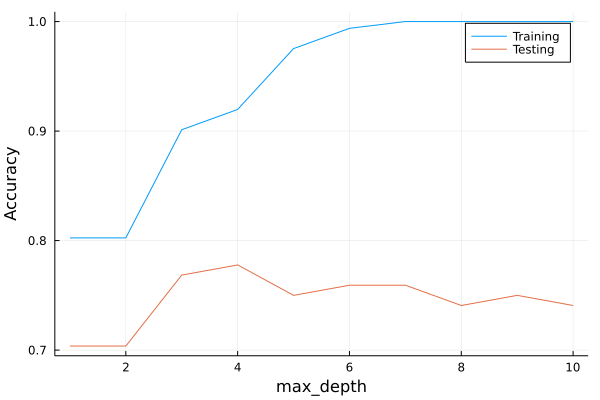

In [107]:
accu_tr = []
accu_te = []
ds = 1:10
for depth in ds
    model1 = DecisionTreeClassifier(max_depth=depth)
    mach = machine(model1, X, y)
    fit!(mach, rows=train, verbosity=0)
    push!(accu_tr, accuracy(predict_mode(mach, rows=train), y[train]))
    push!(accu_te, accuracy(predict_mode(mach, rows=test), y[test]))
    
end

plot(ds, accu_tr, label="Training")
plot!(ds, accu_te, label="Testing", xlabel= "max_depth", ylabel= "Accuracy", fmt = :png)

In [108]:
# max_depth = 3 we have got the highest accuracy

In [109]:
model1 = DecisionTreeClassifier(min_samples_leaf=2,max_depth = 3)
mach = machine(model1, X, y)
train, test = partition(eachindex(y), 0.6, shuffle=true);  
fit!(mach, rows=train, verbosity=0)
yhat = predict_mode(mach, rows=train)
accuracy(yhat, y[train])
yhat1 = predict_mode(mach, rows=test)

accuracy(yhat1, y[test])

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=DecisionTreeClassifier @823`:
│ scitype(X) = Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{3}}, AbstractVector{OrderedFactor{3}}, AbstractVector{OrderedFactor{2}}, AbstractVector{OrderedFactor{4}}}}
│ input_scitype(model) = Table{var"#s46"} where var"#s46"<:Union{AbstractVector{var"#s9"} where var"#s9"<:Count, AbstractVector{var"#s9"} where var"#s9"<:OrderedFactor, AbstractVector{var"#s9"} where var"#s9"<:Continuous}.
└ @ MLJBase C:\Users\kapil\.julia\packages\MLJBase\KWyqX\src\machines.jl:91


0.8240740740740741

In [110]:
@btime DecisionTreeClassifier(min_samples_leaf=2,max_depth = 3)

  143.075 ns (1 allocation: 96 bytes)


DecisionTreeClassifier(
    max_depth = 3,
    min_samples_leaf = 2,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0,
    pdf_smoothing = 0.0,
    display_depth = 5,
    rng = Random._GLOBAL_RNG()) @139